# 線形多層ニューラルネットワークにおける陰的正則化とIRMAE

この記事は以下の論文の再現実装を中心とし、線形多層ニューラルネットワークにおける陰的ランク最小化について解説を行います。

> Jing, L., Zbontar, J. & LeCun, Y. **Implicit Rank-Minimizing Autoencoder**. *NeurIPS' 20*, 2020. <https://arxiv.org/abs/2010.00679>

## 線形多層ニューラルネットワークおける勾配降下法による低ランク解の獲得
一般的なニューラルネットワークにおいて非線形な活性化関数はなぜ必要か、という質問に対する簡単な解答は「複数の線形写像 (or アフィン写像)の合成は1つの線形写像 (or アフィン写像)で表せる」というものです。簡単な例で説明しましょう。まず、入力を$\mathbf{x}$, 出力を$\mathbf{y}$, 重み行列を$W_1, W_2$とした2層の線形ニューラルネットワークを仮定します。このとき

$$
\mathbf{y} = W_1W_2\mathbf{x}
$$

が成り立ちます。しかし、$W = W_1W_2$となる$W$を考えれば、このニューラルネットワークは1層のニューラルネットワークとして

$$
\mathbf{y} = W\mathbf{x}
$$

のように記述できます。これでは多層にする意味がないというわけです。しかし、**勾配降下法で学習させると**両者の学習ダイナミクスは異なるものとなり、得られる解にも違いが生まれます。これに関して先行研究がいくつか挙げられているので抜粋します。

- ([Saxe et al., *PNAS*. 2019](https://arxiv.org/abs/1810.10531))では2層の線形ニューラルネットワークを対象にし、連続的な勾配降下が低ランクの解を導くことを理論的に示しています (Saxeらの論文に関しては過去に記事を作成しました：[ニューラルネットワークにおける意味発達の数学理論](https://salad-bowl-of-knowledge.github.io/hp/neuroscience/2019/01/15/semantic_development.html))。
- ([Arora et al., *NeurIPS' 19*. 2019](https://arxiv.org/abs/1905.13655))では深層線形ニューラルネットワークが低ランクの解を導出できることを理論的及び実験的に実証しています。
- ([Gunasekar et al., *NeurIPS' 18*. 2018](https://arxiv.org/abs/1806.00468))では、線形畳み込みニューラルネットワークにおいて勾配降下が正則化作用を持つことを示しています。

証明は省略しますが、([Arora et al., *NeurIPS' 19*. 2019](https://arxiv.org/abs/1905.13655))におけるTheorem 3.を紹介します。まず、$N$層の線形多層ニューラルネットワークを考え、$W_j \in \mathbb{R}^{d_j \times d_{j−1}}$を$j$層の重みとします(バイアスは省略します)。$t$を学習のタイムステップとし、$W(t) \in \mathbb{R}^{d \times d^\prime}$を重み行列を全て乗じた行列とします (ただし$d := d_N, d^\prime := d_0$)。つまり$W(t):=\prod_{j=1}^N W_j(t)$です。

ここで$W(t)$を特異値分解し、$W(t) = U(t)S(t)V^T(t)$と表現します。$S(t)$は対角行列で、その要素を$\sigma_1(t), \cdots , \sigma_{\min\{d, d^\prime\}}(t),$とします。これが$W(t)$の特異値となります。さらに$U(t), V (t)$の列ベクトルをそれぞれ $\mathbf{u}_1(t), \cdots, \mathbf{u}_{\min\{d, d^\prime\}}(t)$, および $\mathbf{v}_1(t), \cdots, \mathbf{v}_{\min\{d,d^\prime \}}(t)$とします。このとき、特異値$ \sigma_r(t)\ (r=1, \cdots, \min\{d,d^\prime \})$の損失関数$\mathcal{L}(W(t))$に対する勾配降下法による変化は

$$
\frac{d \sigma_r(t)}{dt} = - N \cdot \left[\sigma_r(t)\right]^{1 - \frac{1}{N}} \cdot \left\langle \nabla \mathcal{L}(W(t)) , \mathbf{u}_r(t) \mathbf{v}_r^T(t) \right\rangle \tag{1}
$$

と表されます (Arora et al., 2019; Theorem 3)。(1)式で重要なのは$\left[\sigma_r(t)\right]^{1 - \frac{1}{N}}$の項です。これは$N\geq 2$のときに**特異値$\sigma_r(t)\ (\geq 0)$を小さくするような正則化作用が生じる**ことを意味しています。一方で、1層のニューラルネットワーク ($N=1$)の場合 (1)式は

$$
\frac{d \sigma_r(t)}{dt} = - \left\langle \nabla \mathcal{L}(W(t)) , \mathbf{u}_r(t) \mathbf{v}_r^T(t) \right\rangle \tag{2}
$$

となり、正則化作用は消失します。

このように線形多層ニューラルネットワークを勾配降下法で学習させると**陰的正則化(implicit regularization)** により低ランクの解が得られるということが複数の研究により明らかとなっています（線形多層ニューラルネットワークの陰的正則化に関して日本語で書かれた資料としては鈴木大慈先生の[深層学習の数理](https://www.slideshare.net/trinmu/ss-161240890)のスライドp.64, 65があります)。Jingらはこの性質を用い、**Autoencoderに線形層を複数追加**するという簡便な方法で低次元表現を学習する決定論的Autoencoder (**Implicit Rank-Minimizing Autoencoder; IRMAE)** を考案しました。

## IRMAEの実装
ここからはIRMAEを実装し、Jingらの実験を再現することを目標とします。まず必要なライブラリをimportします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

EncoderとDecoderのclassを定義します。このモデルはMNISTデータセットに合わせたものとなっています。また、`z_dims`は潜在空間の次元です。

In [2]:
class Encoder(nn.Module):
    def __init__(self, z_dims):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(256, z_dims)
        
    def forward(self, x):
        h = F.relu(self.conv1(x)) # 32 x 14 x 14
        h = F.relu(self.conv2(h)) # 64 x 7 x 7
        h = F.relu(self.conv3(h)) # 128 x 3 x 3
        h = F.relu(self.conv4(h)) # 256 x 1 x 1
        h = torch.flatten(h, start_dim=1) # 256
        z = self.fc(h)
        return z

class Decoder(nn.Module):
    def __init__(self, z_dims):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=z_dims, out_features=128*7*7)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        h = self.fc(x)
        h = torch.reshape(h, (-1, 128, 7, 7)) # 128 x 7 x  7
        h = F.relu(self.conv1(h))             # 64 x  7 x  7
        h = F.relu(self.conv2(h))             # 32 x 14 x 14
        y = torch.tanh(self.conv3(h))         # 1 x 28 x 28
        return y

IRMAEの全体のモデルを定義します。やることはEncoderの後に`z_dims`×`z_dims`の重み行列を持つ線形層を複数挿入するだけです。単にIRMAEを実装するだけなら次のような実装は不要ですが、Jingらによる比較実験を再現するために追加する層の設定ができるようにしています。まず、`num_linear_layers`は追加する層の数 (あるいは線形変換の回数)です。`model_type`は3つの型を選べるようになっており、`linear`は通常のIRMAEで、`nonlinear`は線形変換の後にReLU関数を挿入したもの、`weight_share`は線形層の重みを共有したものです。Jingらはさらに線形層の重みを学習させない`fixed`という型についても実験していますが、今回は省略します。なお、通常のAutoencoderの場合は`num_linear_layers=0, model_type="linear"`とします。

In [3]:
# Implicit Rank-Minimizing Autoencoder
class IRMAE(nn.Module):
    def __init__(self, z_dims, num_linear_layers=4, model_type="linear"):
        self.num_linear_layers = num_linear_layers
        super(IRMAE, self).__init__()
        self.encoder = Encoder(z_dims)
        self.decoder = Decoder(z_dims)
        
        if model_type == "linear":
            self.forward = self.forward_linear
            self.linear_layers = nn.ModuleList([nn.Linear(z_dims, z_dims) for _ in range(num_linear_layers)])
        elif model_type == "nonlinear":
            self.forward = self.forward_nonlinear
            self.linear_layers = nn.ModuleList([nn.Linear(z_dims, z_dims) for _ in range(num_linear_layers)])
        elif model_type == "weight_share":
            self.forward = self.forward_weight_share
            self.linear_layer = nn.Linear(z_dims, z_dims)
            
    def forward_linear(self, x):
        z = self.encoder(x)
        for layer in self.linear_layers:
            z = layer(z)
        x_reconst = self.decoder(z)
        return x_reconst, z

    def forward_nonlinear(self, x):
        z = self.encoder(x)
        for layer in self.linear_layers:
            z = layer(F.relu(z))
        x_reconst = self.decoder(z)
        return x_reconst, z
    
    def forward_weight_share(self, x):
        z = self.encoder(x)
        for _ in range(self.num_linear_layers):
            z = self.linear_layer(z)
        x_reconst = self.decoder(z)
        return x_reconst, z

## MNISTデータでの学習
MNISTデータで学習するための関数を定義します。簡略化のためにvalidationによる精度の検証はしていません (今回の趣旨には影響ありません)。

In [4]:
def train(z_dims=128, num_linear_layers=4, model_type="linear", n_epochs=50, lr=1e-4, save_model=False):
    model = IRMAE(z_dims, num_linear_layers, model_type).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss = np.zeros(n_epochs)
    
    print("Start　training...")
    for epoch in  tqdm(range(n_epochs)):
        losses = []
        model.train()
        for x, _ in dataloader_train:
            x = x.to(device)
            model.zero_grad()
            x_reconst, _ = model(x)
            loss = F.mse_loss(x_reconst, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().detach().numpy())  

        train_loss[epoch] = np.mean(losses)
        tqdm.write('EPOCH [%d/ %d], Train Loss:%lf' % (epoch+1, n_epochs, train_loss[epoch]))
        
    if save_model:
        print("Saving model...")
        model_path = 'model_'+str(model_type)+'.pth'
        torch.save(model.state_dict(), model_path)
    return model, train_loss

次にテストデータに対して潜在変数$z$の共分散行列`cov_z`と共分散行列の特異値`s`を取得する関数を定義します。今回のモデルでは潜在変数の次元`z_dims`を128としたため、MNISTのテスト画像10000枚に対する出力 `latents`は 10000 × 128の行列となります。この共分散行列を`np.cov`で計算し、結果を`np.linalg.svd`で特異値分解しています。なお、この際にテストデータに対する誤差も計算しています。

In [5]:
def get_singular_values(model, z_dims=128):
    latents = []
    losses = []   
    model.eval()    
    for x, _ in tqdm(dataloader_test):
        with torch.no_grad():
            x = x.to(device)
            model.zero_grad()
            x_reconst, z = model(x)
          
            loss = F.mse_loss(x_reconst, x)
            losses.append(loss.cpu().detach().numpy())  
            
            latents.append(z)    
            
    print("Test Loss : ", np.mean(losses))
    latents = torch.cat(latents)
    cov_z = np.cov(latents.T.cpu().detach().numpy())
    _, s, _ = np.linalg.svd(cov_z)
    return cov_z, s / s.max()

データセットを読み込みます。今回はMNISTを用います。NNの出力における活性化関数にtanhを用いているので、`transform`においては$[0, 1]$のデータを$[-1, 1]$の範囲に変換しています。

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # [0, 1] to [-1, 1]
    ])

batch_size = 32
device = 'cuda'

dataset_train = datasets.MNIST(root='./data/MNIST', download=True, train=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
                              num_workers=2, pin_memory=True, shuffle=True)
dataset_test = datasets.MNIST(root='./data/MNIST', download=True, train=False, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, 
                             num_workers=2, pin_memory=True, shuffle=False)

通常のAE, IRMAE, IRMAE(非線形), IRMAE(重み共有)の4つのモデルを学習させ、それぞれのテストデータに対する活動から潜在変数の共分散行列とその特異値を取得します。

In [7]:
z_dims = 128
ModelTypeList = ["linear", "linear", "nonlinear", "weight_share"]
NumLinearLayersList = [0, 8, 8, 8]
ModelLabelList = ["AE", "IRMAE", "IRMAE - nonlinear", "IRMAE - share weights"]
num_model_type = len(ModelTypeList)

ModelList = []
LossList = []
CovList = []
SingularValuesList = []

for i in range(num_model_type):
    print("Model type: ", ModelLabelList[i])
    model, train_loss = train(z_dims=z_dims, num_linear_layers=NumLinearLayersList[i], model_type=ModelTypeList[i])
    cov_z, singular_values = get_singular_values(model)
    
    ModelList.append(model)
    LossList.append(train_loss)
    CovList.append(cov_z)
    SingularValuesList.append(singular_values)

## 結果の描画
### 訓練誤差
学習時の訓練損失を描画します。訓練時の再構成誤差は普通のAEが優れているという結果となりました。IRMAEの場合は陰的正則化作用が生じているので、AEよりも訓練誤差が大きくなるのは理解できると思います (VAEの場合にも再構成誤差と正則化のトレードオフが生じます)。

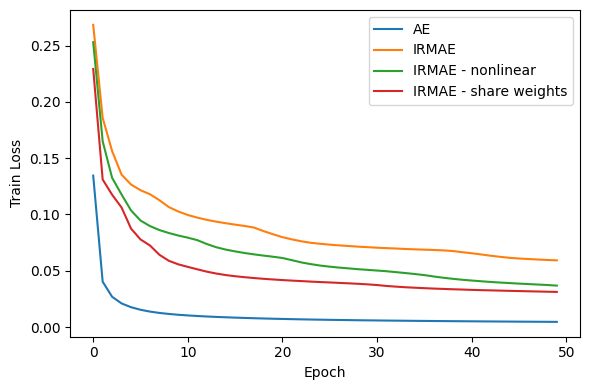

In [8]:
plt.figure(figsize=(6, 4), dpi=100)
for i in range(num_model_type):
    plt.plot(LossList[i], label=ModelLabelList[i])
plt.xlabel('Epoch'); plt.ylabel('Train Loss')
plt.legend(); plt.tight_layout()
plt.show()

### 潜在空間の特異値
各モデルの潜在空間の特異値(最大値1に正規化)の結果を表示します。ここでは差異が分かるように描画する特異値の範囲を制限しています。

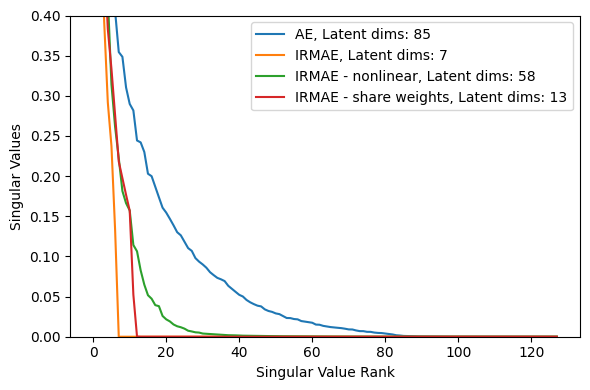

In [9]:
plt.figure(figsize=(6, 4), dpi=100)
for i in range(num_model_type):
    plt.plot(SingularValuesList[i], label=ModelLabelList[i]+", Latent dims: "+str(np.linalg.matrix_rank(CovList[i], tol=1e-2)))
plt.xlabel('Singular Value Rank'); plt.ylabel('Singular Values')
plt.ylim(0, 0.4)
plt.legend(); plt.tight_layout()
plt.show()

IRMAEの潜在空間の次元は7 (ただし0.01を閾値としている)となっており、他のモデルよりも次元が低いことが分かります。興味深いのは重み共有したIRMAEにおいても潜在空間の次元が13と、AEに比べて小さくなっている点です (さらに再構成誤差も通常のIRMAEに比べて小さい)。重み共有の場合はAEに線形RNNを挟んでいるようなものなので、RNNの場合にも拡張できるのではと思いました (既に研究されていると思いますが)。

### 潜在空間の多様体の可視化及びモデル間での比較
最後に2つの入力に対する潜在変数を線形補間し、それをデコードすることで潜在空間の多様体を可視化してみましょう。ここではAEとIRMAEに対して検討してみます。

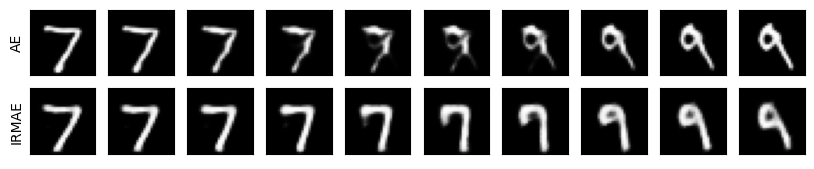

In [10]:
fig = plt.figure(figsize=(10, 4), dpi=100)
for i in range(2):
    model = ModelList[i]
    model.eval()

    x0, _ = dataset_test[0]
    x0 = x0.to(device).unsqueeze(0)
    y0, z0 = model(x0)

    x1, _ = dataset_test[7]
    x1 = x1.to(device).unsqueeze(0)
    y1, z1 = model(x1)

    z_linear = torch.cat([z1 * (i * 0.1) + z0 * ((9 - i) * 0.1) for i in range(10)])
    z_linear = z_linear.view((10, -1))
    y2 = model.decoder(z_linear).view(-1, 28, 28)
    for j, im in enumerate(y2.cpu().detach().numpy()):
        idx = i*10+j+1
        plt.subplot(num_model_type, 10, idx, xticks=[], yticks=[])
        plt.imshow(im, 'gray')
        if idx % 10 == 1:
            plt.ylabel(ModelLabelList[i])
plt.show()

AEよりもIRMAEの方が2枚の画像を綺麗に補間できていることが分かります。Jingらは生成画像を確率的モデルであるVAEと比較しています。VAEには生成画像がぼやけるという欠点がありますが、IRMAEはCelebAデータセットにおいてVAEよりも良質な画像 (FID scoreの小さい画像) を生成するという結果が報告されています。なお、Jingらは純粋なVAEのみと比較しており、例えばNVAE ([Vahdat & Kautz, *NeurIPS' 20*, 2020](https://arxiv.org/abs/2007.03898)) などとは比較していません。

## まとめ
- 線形層を挿入するという簡単な操作はネットワークの陰的正則化作用を生み出す。
- 上記の理論をAEに応用したIRMAEは、潜在空間の分布として多変量標準正規分布を仮定するといった明示的な正則化なしでVAEのような潜在空間を獲得できる。

## 参考文献
1. Jing, L. et al., [Implicit Rank-Minimizing Autoencoder](https://arxiv.org/abs/2010.00679). *NeurIPS' 20*, 2020. 
1. <https://github.com/facebookresearch/irmae>
1. Saxe, A.M. et al., [A mathematical theory of semantic development in deep neural networks](https://arxiv.org/abs/1810.10531). *PNAS*, 2019.
1. Arora, A. et al., [Implicit regularization in deep matrix factorization](https://arxiv.org/abs/1905.13655). *NeurIPS' 19*, 2019.
1. Gunasekar, S. et al., [Implicit bias of gradient descent on linear convolutional networks](https://arxiv.org/abs/1806.00468). *NeurIPS ’18*, 2018.
1. [Implicit Rank Minimization in Gradient Descent](https://dibyadas.github.io/posts/irmae/)